# 如何进行用户个性化检索

本指南演示了如何配置检索链的运行时属性。一个示例应用场景是根据用户限制可用于[检索器](/docs/concepts/retrievers/)的文档。

在构建[检索应用](/docs/concepts/rag/)时，您通常需要考虑多个用户。这意味着您可能存储的不仅仅是一个用户的数据，而是许多不同用户的数据，并且他们不应该能够看到彼此的数据。这意味着您需要能够配置检索链，以便仅检索某些信息。这通常涉及两个步骤。

**步骤 1：确保您使用的检索器支持多个用户**

目前，LangChain 中没有统一的标志或过滤器来实现这一点。相反，每个向量存储和检索器可能有自己的方式，并且其名称可能不同（例如命名空间、多租户等）。对于向量存储，这通常通过在调用 `similarity_search` 时传递的关键字参数来暴露。通过阅读文档或源代码，确定您使用的检索器是否支持多个用户，如果支持，则了解如何使用它。

注意：为不支持（或未记录）多用户的检索器添加文档和/或支持是为 LangChain 做出贡献的绝佳方式。

**步骤 2：将该参数添加为链的可配置字段**

这将允许您轻松调用链并在运行时配置任何相关标志。有关配置的更多信息，请参阅[此文档](/docs/how_to/configure)。

现在，在运行时，您可以使用可配置字段调用此链。

## 代码示例

让我们通过一个具体的代码示例来看看这是什么样子的。我们将在此示例中使用 Pinecone。

要配置 Pinecone，请设置以下环境变量：

- `PINECONE_API_KEY`: 您的 Pinecone API 密钥

In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

embeddings = OpenAIEmbeddings()
vectorstore = PineconeVectorStore(index_name="test-example", embedding=embeddings)

vectorstore.add_texts(["I worked at Kensho"], namespace="harrison")
vectorstore.add_texts(["I worked at Facebook"], namespace="ankush")

['f907aab7-77c7-4347-acc2-6859f8142f92']

`namespace` 参数可以用来分隔文档

In [4]:
# This will only get documents for Ankush
vectorstore.as_retriever(search_kwargs={"namespace": "ankush"}).invoke(
    "where did i work?"
)

[Document(id='f907aab7-77c7-4347-acc2-6859f8142f92', metadata={}, page_content='I worked at Facebook')]

In [5]:
# This will only get documents for Harrison
vectorstore.as_retriever(search_kwargs={"namespace": "harrison"}).invoke(
    "where did i work?"
)

[Document(id='16061fc5-c6fc-4f45-a3b3-23469d7996af', metadata={}, page_content='I worked at Kensho')]

现在，我们可以创建将用于进行问答的链。

首先，让我们选择一个 LLM。

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [6]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

这将遵循 [RAG 教程](/docs/tutorials/rag) 中的基本实现，但我们将允许检索步骤可配置。

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import ConfigurableField

template = """Answer the question based only on the following context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

retriever = vectorstore.as_retriever()

在这里，我们将检索器标记为一个具有可配置字段的对象。所有向量存储检索器都有一个 `search_kwargs` 字段。这只是一个字典，其中包含向量存储特定的字段。

这将允许我们在调用链时传入 `search_kwargs` 的值。

In [8]:
configurable_retriever = retriever.configurable_fields(
    search_kwargs=ConfigurableField(
        id="search_kwargs",
        name="Search Kwargs",
        description="The search kwargs to use",
    )
)

现在，我们可以使用可配置的检索器来创建链。

In [9]:
from langchain_core.documents import Document
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# highlight-next-line
def retrieve(state: State, config: RunnableConfig):
    # highlight-next-line
    retrieved_docs = configurable_retriever.invoke(state["question"], config)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

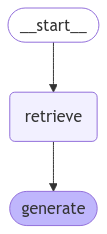

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

我们现在可以配置选项来调用链。`search_kwargs` 是可配置字段的 id。其值是用于 Pinecone 的搜索 kwargs。

In [13]:
result = graph.invoke(
    {"question": "Where did the user work?"},
    config={"configurable": {"search_kwargs": {"namespace": "harrison"}}},
)

result

{'question': 'Where did the user work?',
 'context': [Document(id='16061fc5-c6fc-4f45-a3b3-23469d7996af', metadata={}, page_content='I worked at Kensho')],
 'answer': 'The user worked at Kensho.'}

In [14]:
result = graph.invoke(
    {"question": "Where did the user work?"},
    config={"configurable": {"search_kwargs": {"namespace": "ankush"}}},
)

result

{'question': 'Where did the user work?',
 'context': [Document(id='f907aab7-77c7-4347-acc2-6859f8142f92', metadata={}, page_content='I worked at Facebook')],
 'answer': 'The user worked at Facebook.'}

如需了解操作特定向量存储的详细信息，请参阅[集成页面](/docs/integrations/vectorstores/)。